# ДЗ №2
### *виконала студентка групи ФБ-33 Журавльова Марія* ###

Нагадаю, що мій набір даних - TMDB 10000 Movies Dataset (https://www.kaggle.com/datasets/i0xc0d3x00000/tmdb-10000-movies-dataset)

**Опис колонок:**

- title - назва фільму;
- overview - опис сюжету фільму;
- release_date - оригінальна дата випуску;
- vote_average - середній рейтинг фільму;
- vote_count : кількість отриманих голосів;
- original_language - мова зйомки;
- popularity - індекс популярності.

### Метод к-середніх:
- Надати оптимальну кількість кластерів (Наприклад, метод ліктя. Якщо інший, то напишіть який саме використовували. Намалювати графік, який відображає оптимальність кластерів);
- Надати таблицю з цетрами кластерів та кількістю елементів;
- Намалювати кластери різними кольорами на одній сітці та їх центри.
Також вказуйте, яку метрику ви використовували для визначення радіусу кластера(евклідову, манхетенську тощо).

Я буду використовувати sclearn.cluster.KMeans (реалізацію алгоритму кластеризації k-means у бібліотеці scikit-learn). Оскільки алгоритм k-means обчислює відстані між точками, то я додатково підготовую дані (стандартизація), щоб не було спотворення результату через виміри vote_average (0-10) та vote_count (тисячі голосів). Також слід зауважити, що флгоритм k-means н scikit-learn завжди використовує евклідову метрику.

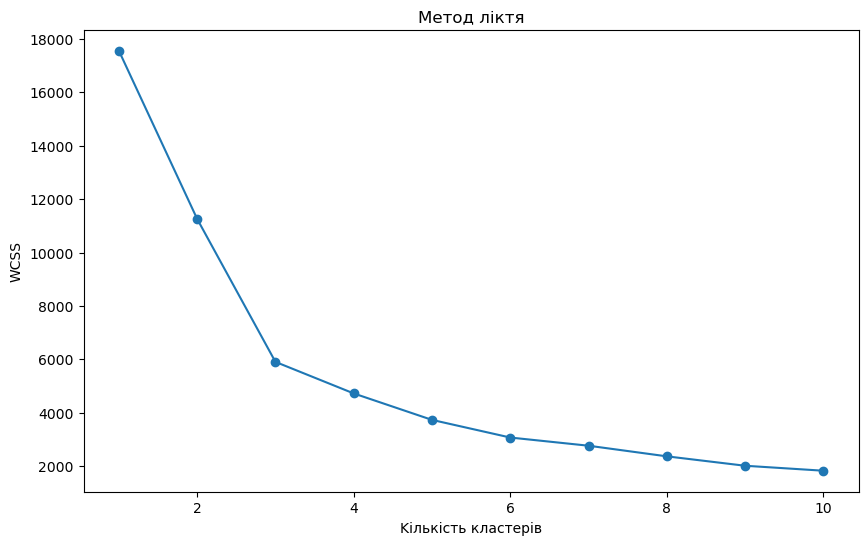

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# завантажую дані
df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\university\МТАД\movie_tmdb_clean.csv")
x = df[['vote_average', 'vote_count']]

# маштабування (стандартизація даних)
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

# Метод ліктя
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=100)
    kmeans.fit(scaled_x)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Метод ліктя')
plt.xlabel('Kількість кластерів')
plt.ylabel('WCSS')
plt.show()

Можна зробити висновок, що оптимальна кількість кластерів становить ***3***, оскільки після цієї точки графік спадає значно плавніше.

In [2]:
# k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_x)

df_clusters = x.copy()
df_clusters['clusters'] = clusters

# центри кластерів
centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_centers = pd.DataFrame(centers, columns=['vote_average', 'vote_count'])
df_centers.index.name = 'clusters'

# кількість елементів у кожному кластері
counts_kmean = df_clusters['clusters'].value_counts().sort_index()
df_centers['count'] = counts_kmean.values

print("Таблиця з цетрами кластерів та кількістю елементів:\n")
print(df_centers)

Таблиця з цетрами кластерів та кількістю елементів:

          vote_average   vote_count  count
clusters                                  
0             6.763735  2212.992006   1378
1             6.165047   532.318410   4177
2             7.291039   565.780775   3223


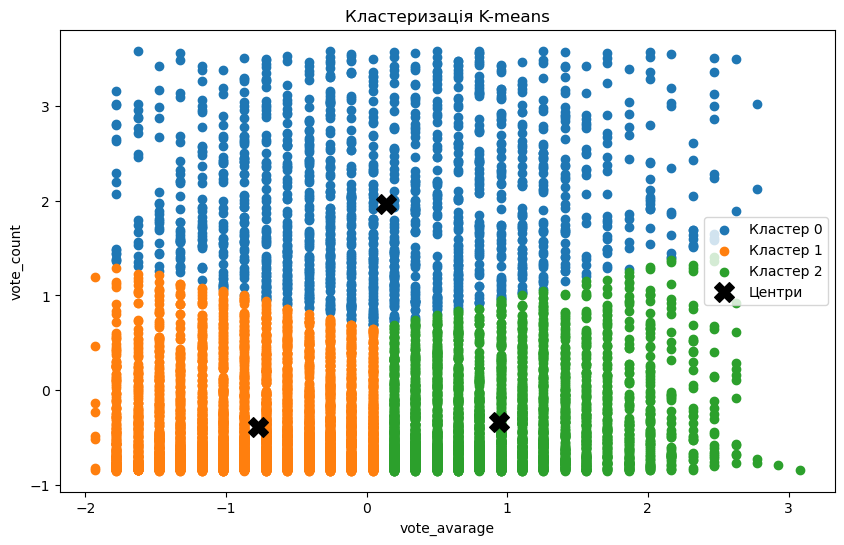

In [3]:
# Візуалізація кластерів
plt.figure(figsize=(10,6))
for c in range(3):
    cluster_points = scaled_x[clusters == c]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f'Кластер {c}')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            c='black', s=200, marker='X', label='Центри')
plt.xlabel('vote_avarage')
plt.ylabel('vote_count')
plt.title('Кластеризація K-means')
plt.legend()
plt.show()

(Координати на графіку - стандартизовані значення)

- Кластер 0 - можна зробити припущення, що це якісь популярні фільми, оскільки рейтинг варіюється, але аудиторія велика.
- Кластер 1 - мабуть непопулярні фільми, оскільки мають середні рейтинги та низьку кількість голосів.
- Кластер 2 - можливо нові фільми, оскільки кількість голосів невелика, а рейтинги високі.

### Ієрархічний метод:
- Намалювати дендограму;
- Визначити оптимальну кількість кластерів: якщо з візувалізації, по поясніть, чому саме така кількість кластерів;
- Надати таблицю з кількістю елементів по кластерам.

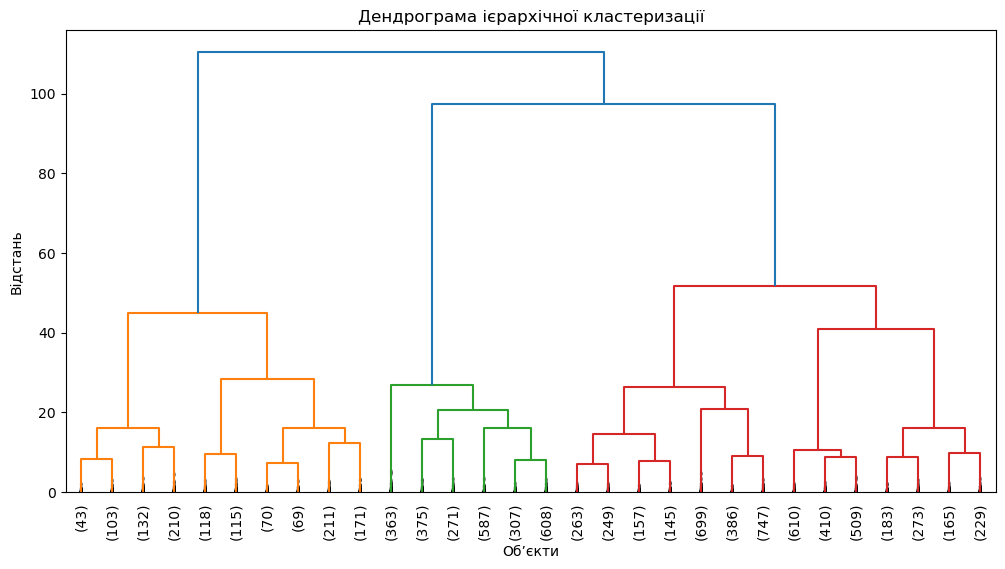

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram

# ward linkage - евклідова відстань
Z = linkage(scaled_x, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Дендрограма ієрархічної кластеризації')
plt.xlabel('Об’єкти')
plt.ylabel('Відстань')
plt.show()

На дендограмі можна побачити, що найбільш довга вертикальна лінія знаходиться на відстані ~90-95. Якщо провести горизонтальну лінію на цій висоті, вона перетне 3 вертикальні лінії, а отже, оптимальна кількість кластерів буде ***3***.

In [5]:
from scipy.cluster.hierarchy import fcluster

# Кластерізація k=3
clusters_hier = fcluster(Z, 3, criterion='maxclust')

df_hier = x.copy()
df_hier['cluster_hier'] = clusters_hier

# Кількість елементів у кожному кластері
counts_hier = df_hier['cluster_hier'].value_counts().sort_index()

print("Кількість елементів у кожному кластері:\n")
print(counts_hier)

Кількість елементів у кожному кластері:

cluster_hier
1    1242
2    2511
3    5025
Name: count, dtype: int64


In [6]:
counts_hier.index = counts_hier.index - 1
counts_hier = counts_hier.sort_index()

comparison = pd.DataFrame({
    'KMeans_count': counts_kmean,
    'Hierarchical_count': counts_hier
})
print("\nПорівняння кількості об’єктів у кластерах:\n")
print(comparison)


Порівняння кількості об’єктів у кластерах:

   KMeans_count  Hierarchical_count
0          1378                1242
1          4177                2511
2          3223                5025


**Висновок:** хоча кількість кластерів одна й та сама, кількість елементів різна. Основна причина такої відмінності полягає у логіці алгоритмів. K-means орієнтований на мінімізацію відстаней до центрів і прагне до більш "збалансованих" груп, тоді як ієрархічний метод поєтапно об'єднує об'єкти і може створити один великий кластер, якщо у даних є щільна область. Тому якщо для аналізу важлива рівномірність кластерів, то краще обрати k-means.